# Context for the Data
"COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable." For the purposes of this implementation, we will not be focusing on the aspects of the data that are attributed with the compas scores or predictions, but using the variables to predict a binary recidivism and compare with the ground truth value for recidivism within the dataset. This will be performed in the Machine Learning Implementation section of the notebook, which includes the implementation of the feature blindness and the comparitive analysis.   

### What are we going to perform on this notebook?
* For this we will make use of a dataset available at https://github.com/propublica/compas-analysis.
* We will load the data and perform an exploratory data analysis
* The threshold for establishing measures to prevent recidivism is 7 and above.
* We will create a machine learning model with various data pre-processing techniques to perform a comparitive analysis




# Load and Review Data

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
import warnings
warnings.filterwarnings("ignore")

Use parse dates in pd.read_csv to convert them to time format.

In [131]:
path = "cox-violent-parsed.csv"

date_cols = ["compas_screening_date","dob","c_jail_in","c_jail_out","c_offense_date","v_screening_date","screening_date",
"vr_offense_date","r_jail_out","r_jail_in","r_offense_date","c_arrest_date"]

df = pd.read_csv(path,parse_dates=date_cols)
df.head(3)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Risk of Violence,1,Low,2013-08-14,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Risk of Violence,1,Low,2013-08-14,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,2014-12-31,30/12/2014,03/01/2015,0,3,457,0


In [132]:
# we see an overview where we see the type of data in each column, if there is Nan, the memory usage, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       11001 non-null  float64       
 1   name                     18316 non-null  object        
 2   first                    18316 non-null  object        
 3   last                     18316 non-null  object        
 4   compas_screening_date    18316 non-null  datetime64[ns]
 5   sex                      18316 non-null  object        
 6   dob                      18316 non-null  datetime64[ns]
 7   age                      18316 non-null  int64         
 8   age_cat                  18316 non-null  object        
 9   race                     18316 non-null  object        
 10  juv_fel_count            18316 non-null  int64         
 11  decile_score             18316 non-null  int64         
 12  juv_misd_count           18316 n

In [133]:
# we see that there are a lot of null values, so we will have to make some adjustments later on.
# remember that the prefix r_ stands for recidivist, and vr_ violent recidivist.
nulos = df.isnull().mean()
nulos[nulos >0]

,0
id,0.399378
days_b_screening_arrest,0.070812
c_jail_in,0.070812
c_jail_out,0.070812
c_case_number,0.047336
c_offense_date,0.215768
c_arrest_date,0.831568
c_days_from_compas,0.047336
c_charge_degree,0.047336
c_charge_desc,0.048100


In principle there are no duplicates, but just in case, let's check the names, age, sex, date of birth and breed. Remove duplicate individuals from the data.

In [134]:
df.duplicated().sum()

0

In [135]:
 df[df.duplicated(["name","age","sex","race","dob"],keep=False)]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Risk of Violence,1,Low,2013-08-14,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Risk of Violence,1,Low,2013-08-14,07/07/2014,14/07/2014,0,334,961,0
4,5.0,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Risk of Violence,3,Low,2013-04-14,16/06/2013,16/06/2013,4,0,63,0
5,6.0,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Risk of Violence,3,Low,2013-04-14,30/07/2013,08/11/2013,4,63,107,0
6,7.0,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Risk of Violence,3,Low,2013-04-14,27/03/2014,02/05/2014,4,208,347,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18306,NaN,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,Risk of Violence,9,High,2013-10-20,07/04/2014,27/04/2014,0,0,169,0
18307,NaN,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,Risk of Violence,9,High,2013-10-20,04/03/2015,11/03/2015,0,189,500,0
18308,NaN,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,Risk of Violence,9,High,2013-10-20,04/03/2015,11/03/2015,0,507,894,0
18314,NaN,florencia sanmartin,florencia,sanmartin,2014-06-30,Female,1992-12-18,23,Less than 25,Hispanic,...,Risk of Violence,4,Low,2014-06-30,15/03/2015,15/03/2015,2,0,258,0


In [136]:
# Make a filter of columns that can be used for the analysis
columnas_para_filtrar = ["id","compas_screening_date","c_offense_date","sex","age","age_cat","race","c_charge_degree","c_charge_desc",
"days_b_screening_arrest", "decile_score", "is_recid","r_offense_date", "c_case_number","v_decile_score",
"is_violent_recid","vr_offense_date","score_text"]
df_final = df.loc[:,columnas_para_filtrar].copy()

# Now we will pass a series of filters to leave the dataframe ready for analysis:




In [137]:
# filter, we will keep rows that have a case number
df_final = df_final[df_final["c_case_number"] != "NaN"]

In [138]:
# we pass a filter based on the days that pass without charging a crime after being arrested (days_b_screening_arrest);
# looking at the data we see that 75% of the data is less than -1 (with some extreme data - 576,1057);
# for data quality reasons, we will use up to 30 days after the arrest.
df_final["days_b_screening_arrest"].describe()

,days_b_screening_arrest
count,17019.000000
mean,4.302485
std,81.159881
min,-597.000000
25%,-1.000000
50%,-1.000000
75%,0.000000
max,1057.000000


In [139]:
# filter, we are left with cases where a crime is charged within 30 days of arrest.
df_final = df_final.loc[(df_final["days_b_screening_arrest"] <30) & (df_final["days_b_screening_arrest"] > -30)]

In [140]:
# finally, the -1 values of is_recid, v_decile_score and decile_score, which mean that it has no compass evaluation;
df_final = df_final.loc[(df_final["is_recid"]!=-1) & (df["decile_score"]!=-1) & (df_final["v_decile_score"] !=-1)]

In [141]:
# we convert some columns to categories; in the first ones I want to give an order for visualizations
# using pd.CategoricalDtype.
race_type = pd.CategoricalDtype(categories=['African-American','Caucasian','Hispanic',"Other",'Asian',
'Native American'],ordered=True)
df_final["race"] = df_final["race"].astype(race_type)

score_type = pd.CategoricalDtype(categories=["Low","Medium","High"],ordered=True)
df_final["score_text"] = df_final["score_text"].astype(score_type)

age_type = pd.CategoricalDtype(categories=["Less than 25","25 - 45","Greater than 45"],ordered=True)
df_final["age_cat"] = df_final["age_cat"].astype(age_type)

# the rest with the normal method astype
for col in ["sex","c_charge_degree"]:
    df_final[col] = df_final[col].astype("category")

In [142]:
# we will not count as repeat offenses cases involving traffic tickets and municipal ordinance violations.
# charge degree = O
df_final = df_final[df_final["c_charge_degree"] != "O"]
# and those that also do not have text evaluation (low,medium,high)
df_final = df_final[df_final["score_text"] != "NaN"]

In [143]:
# we also filter out cases in which the date of compas is prior to the date of the commission of the crime.
df_final = df_final[df_final["c_offense_date"] < df_final["compas_screening_date"]]

In [144]:
def two_years(df, col, col_recid):
    # Ensure the columns are in datetime format
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df["compas_screening_date"] = pd.to_datetime(df["compas_screening_date"], errors='coerce')

    # Calculate the difference in days
    df["days"] = (df[col] - df["compas_screening_date"]).dt.days

    # Assign values based on the `col_recid` and `days`
    df["two"] = np.where(
        df[col_recid] == 0, 0,
        np.where((df[col_recid] == 1) & (df["days"] < 730), 1, 3)
    )

    return df["two"]

# Applying the function and creating new columns in df_final
df_final["two_years_r"] = two_years(df_final, "r_offense_date", "is_recid")
df_final["two_years_v"] = two_years(df_final, "vr_offense_date", "is_violent_recid")

In [145]:
# now we remove repeat offenders but for more than two years.
df_final_c = df_final[df_final["two_years_r"] !=3].copy()


# and also for the violent ones
df_final_v = df_final[df_final["two_years_v"] != 3].copy()

df_final_c.reset_index(drop=True,inplace=True)
df_final_v.reset_index(drop=True,inplace=True)

Now I create two new columns that will later help me to extract data more easily:

* one that translates decile score to binary (1,0)
* another one that returns True/False based on whether the Compas prediction is correct.

In [146]:
# I create a column of 0 and 1, with decile score data (scores of 5 and above are considered likely to reoffend ).

df_final_c["binary_decile_score"] = np.where(df_final_c["decile_score"] >=5,1,0)
df_final_v["binary_v_decile_score"] = np.where(df_final_v["v_decile_score"] >=5,1,0)

In [147]:
#we can create a column that returns true if the prediction is correct and false otherwise, for both is_recid and violent_is_recid

df_final_c["recid_comparison_column"] = df_final_c['is_recid'] == df_final_c["binary_decile_score"]

df_final_v["v_recid_comparison_column"] = df_final_v['is_violent_recid'] == df_final_v["binary_v_decile_score"]

In [148]:
# and finally reset the index
df_final_c.reset_index(drop=True,inplace=True)
df_final_v.reset_index(drop=True,inplace=True)

# EDA
After making the appropriate corrections, we are going to make an exploratory analysis of the data where we will see:
* gender
* age
* race


### SEX AND AGE

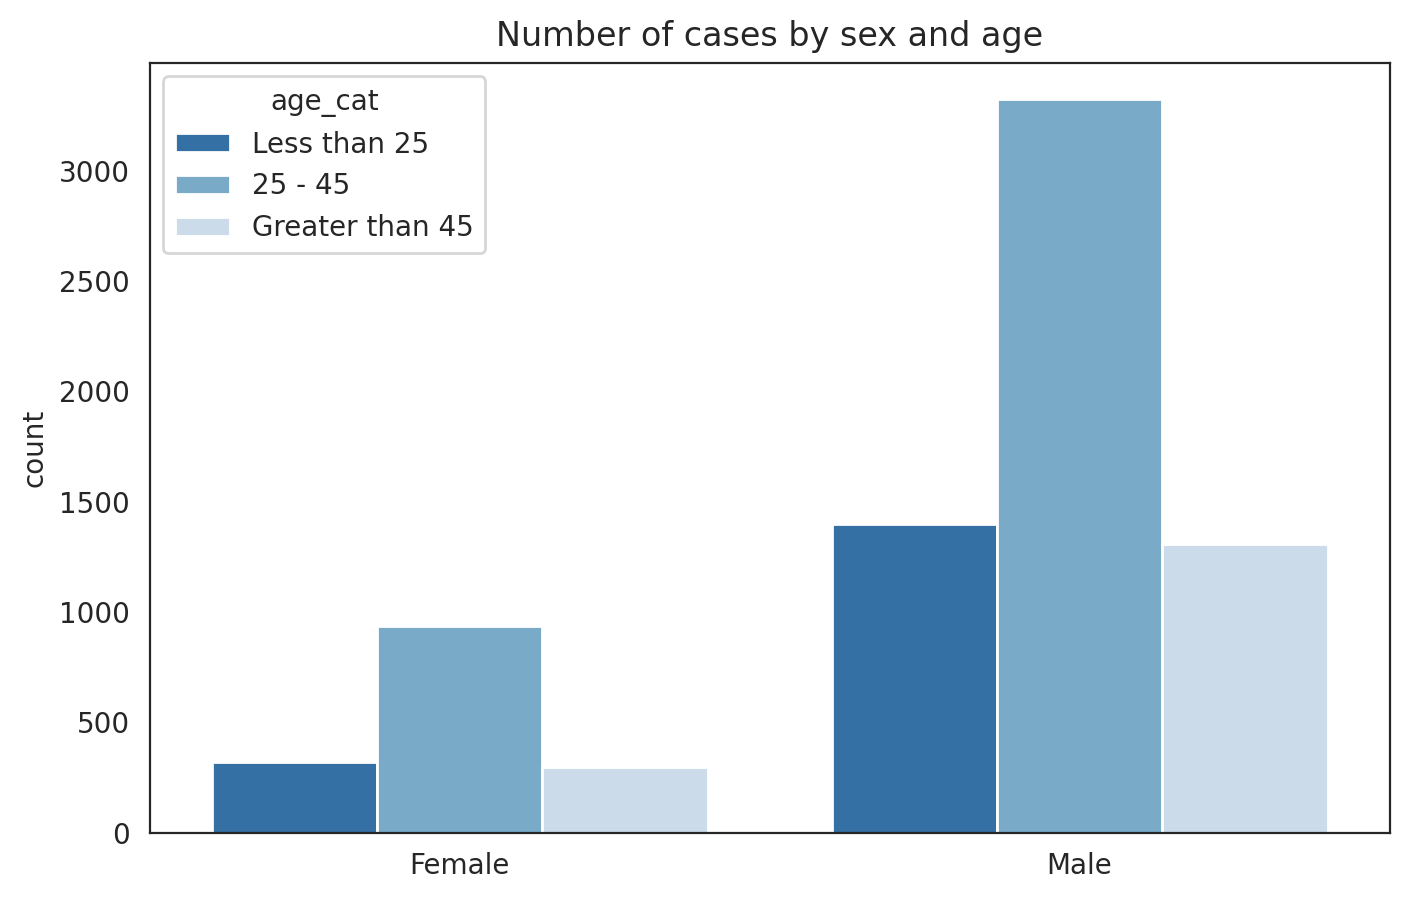

In [149]:
# we will see some data of the dataset according to sex;


plt.figure(figsize=(8,5))
sns.countplot(data=df_final_c,x="sex",hue="age_cat",palette="Blues_r")
plt.title("Number of cases by sex and age")
plt.xlabel("")
plt.show(block=False)

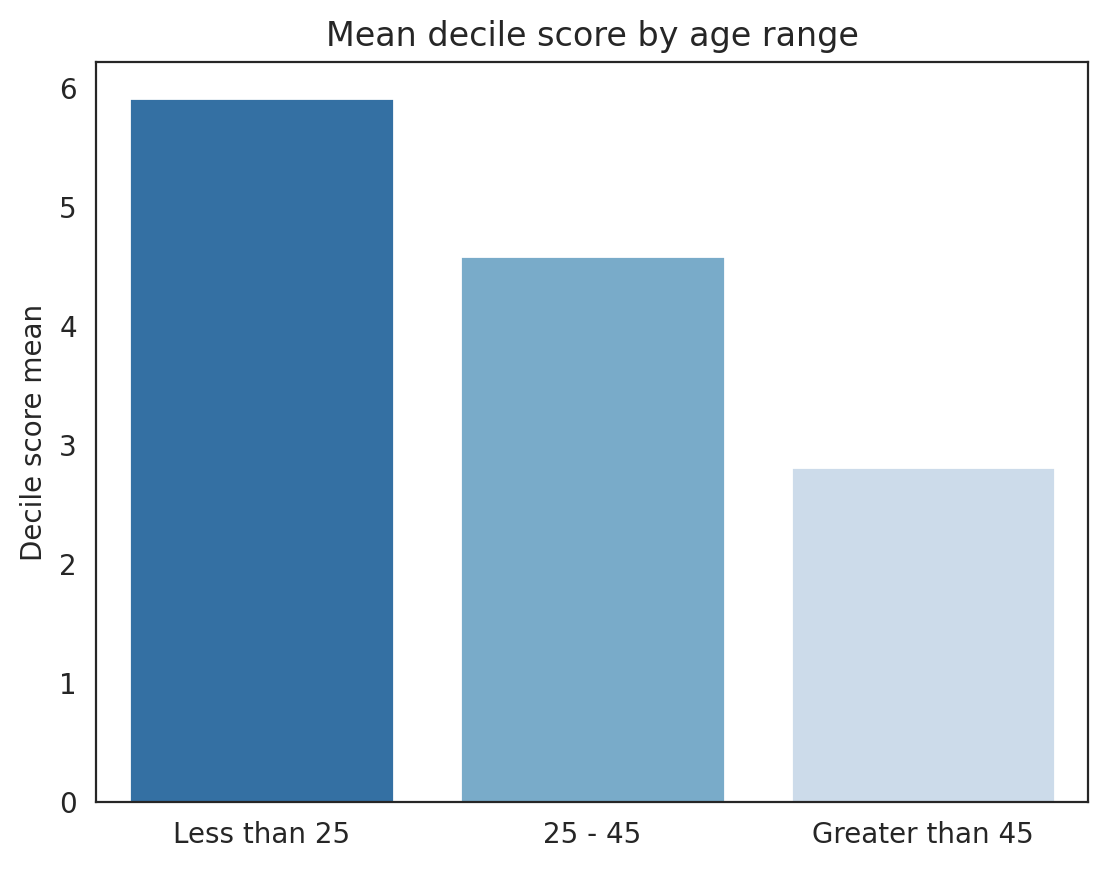

In [150]:
# as we saw before there is a correlation between age and decile score, the younger the more it penalizes.
decile_mean_age = df_final_c.groupby("age_cat")["decile_score"].mean().reset_index()
sns.barplot(data=decile_mean_age,x="age_cat",y="decile_score",palette="Blues_r")
plt.ylabel("Decile score mean")
plt.xlabel("")
plt.title("Mean decile score by age range")
plt.show(block=False)

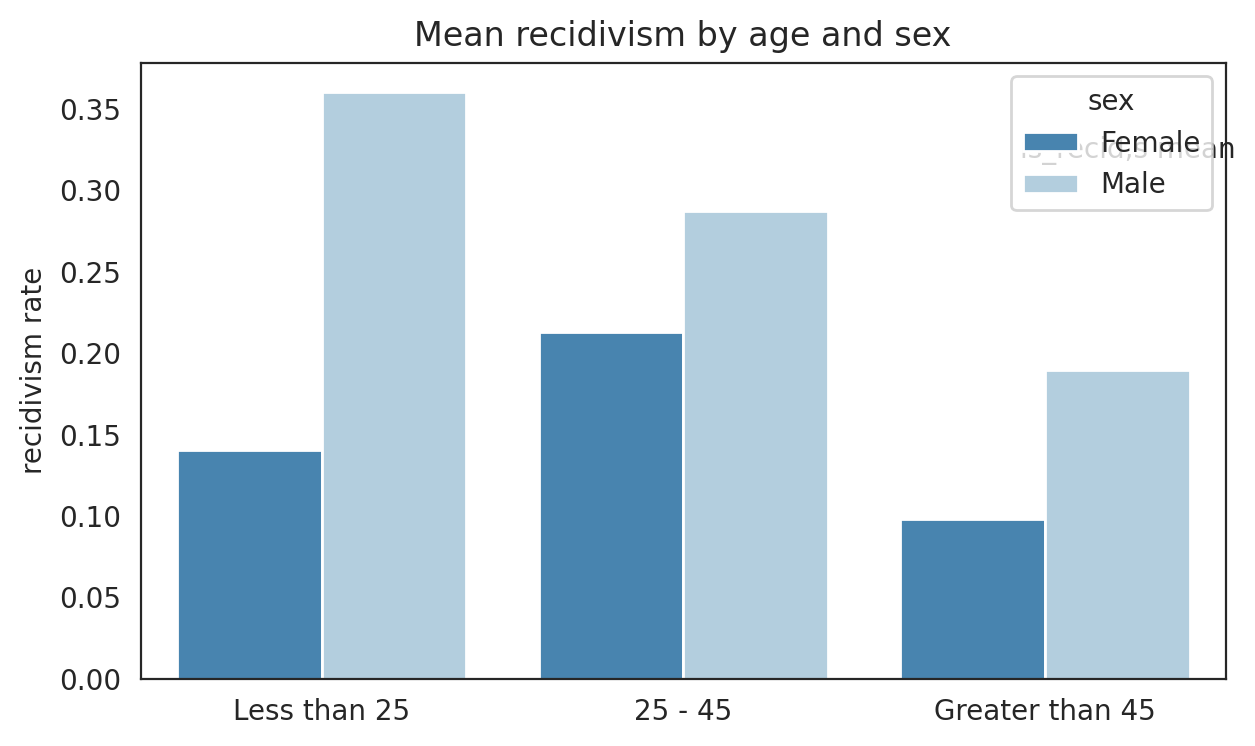

In [151]:
# We can plot the average recidivism rate by age and sex,

sex_edad_recid = df_final_c.groupby(["sex","age_cat"])["two_years_r"].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=sex_edad_recid,x="age_cat",y="two_years_r",hue="sex",palette="Blues_r")
plt.title("Mean recidivism by age and sex")
plt.xlabel("")
plt.ylabel("recidivism rate")
plt.text(x=1.93,y=0.32,s="is_recid,s mean")
plt.show(block=False)

### RACE

* With race, when looking at the statistics, we must always keep in mind that there is very little data on Asians and Native Americans (a good idea would be to group them together with Other in a single category to make it more representative).


* This is important because the dataset is not balanced and can be very biased due to the predominance of this ethnic group.



In [152]:
df_final_c.groupby("race",as_index=False)["two_years_r"].mean().style.background_gradient(cmap='Blues',axis=0)

,race,two_years_r
0,African-American,0.316881
1,Caucasian,0.207533
2,Hispanic,0.219403
3,Other,0.178082
4,Asian,0.162791
5,Native American,0.055556


In [153]:
# we now see the percentage of cases by race and age. In young people under 25 years of age, African-Americans predominate.

# using normalize = 0 we obtain percentages by rows.
pd.crosstab(df_final_c["race"],df_final_c["age_cat"],normalize=0).style.background_gradient(cmap='Blues',axis=1)

age_cat,Less than 25,25 - 45,Greater than 45
race,,,
African-American,0.277238,0.575479,0.147283
Caucasian,0.167179,0.536126,0.296695
Hispanic,0.200000,0.574627,0.225373
Other,0.196347,0.577626,0.226027
Asian,0.139535,0.558140,0.302326
Native American,0.111111,0.444444,0.444444


In [154]:
# We can also look at recidivism percentages by race-age;

pd.crosstab(values=df_final_c["two_years_r"],index=df_final_c["race"],columns=df_final_c["age_cat"],aggfunc="mean")\
    .style.background_gradient(cmap='Blues',axis=1)

age_cat,Less than 25,25 - 45,Greater than 45
race,,,
African-American,0.361742,0.311588,0.253119
Caucasian,0.257471,0.233692,0.132124
Hispanic,0.253731,0.246753,0.119205
Other,0.220930,0.177866,0.141414
Asian,0.166667,0.208333,0.076923
Native American,0.500000,0.000000,0.000000


### COMPAS VS RACE and SEX

We first compare the actual recidivism rate vs. that predicted by Compas; for Caucasians and Hispanics they are very even but for African-Americans the prediction is much higher than actual cases

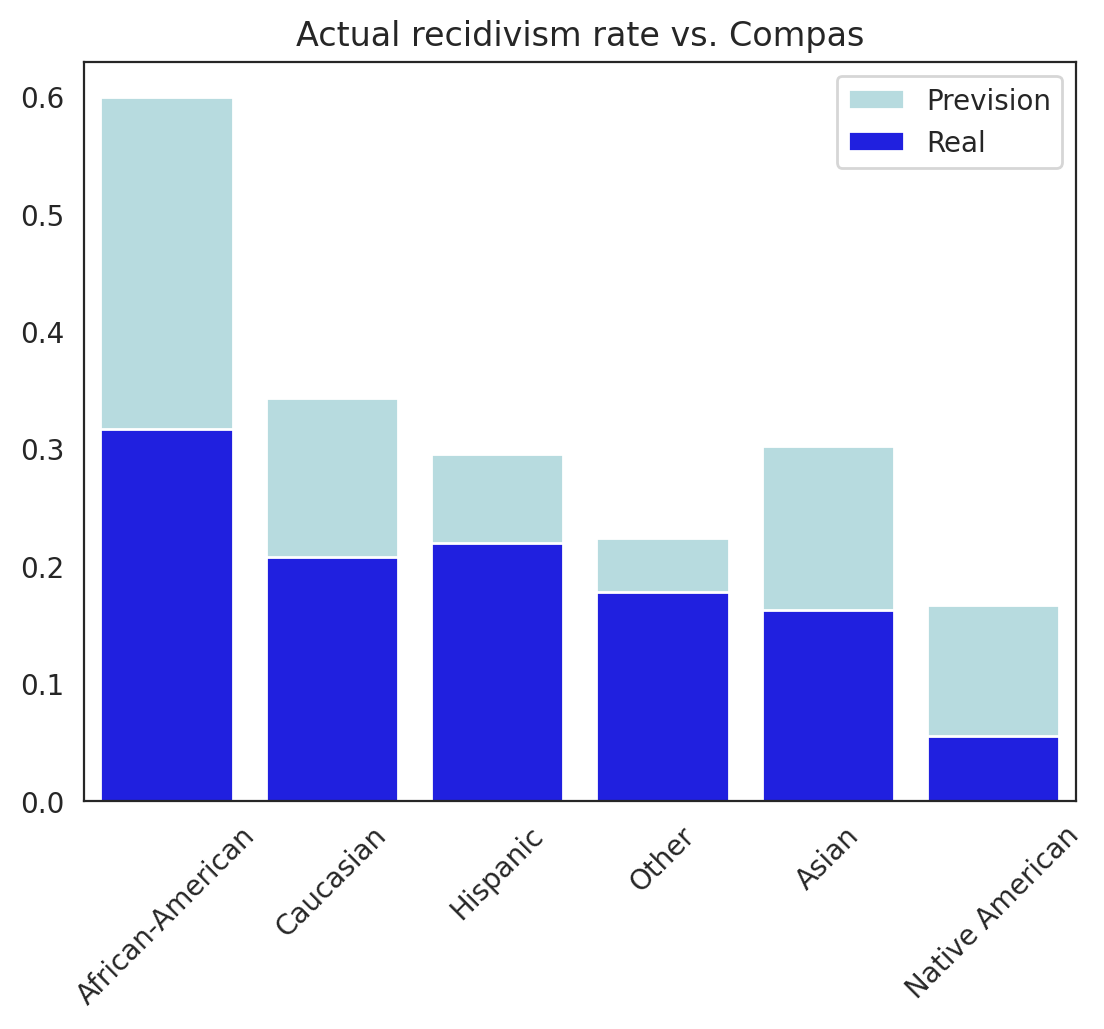

In [155]:
# comparamos reincidencia real vs prevision compas
real = df_final_c.groupby("race",as_index=False)["two_years_r"].mean()
compas = df_final_c.groupby("race")["binary_decile_score"].mean().reset_index()

sns.barplot(data=compas,x="race",y="binary_decile_score",color="powderblue",label="Prevision")

ax= sns.barplot(data=real,x="race",y="two_years_r",color="blue",label="Real")

plt.title("Actual recidivism rate vs. Compas")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")
plt.legend()
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

In [156]:
df_final_c.groupby("race").agg({"two_years_r":"mean",
                                    "binary_decile_score":"mean"})

,two_years_r,binary_decile_score
race,,
African-American,0.316881,0.599370
Caucasian,0.207533,0.343198
Hispanic,0.219403,0.295522
Other,0.178082,0.223744
Asian,0.162791,0.302326
Native American,0.055556,0.166667


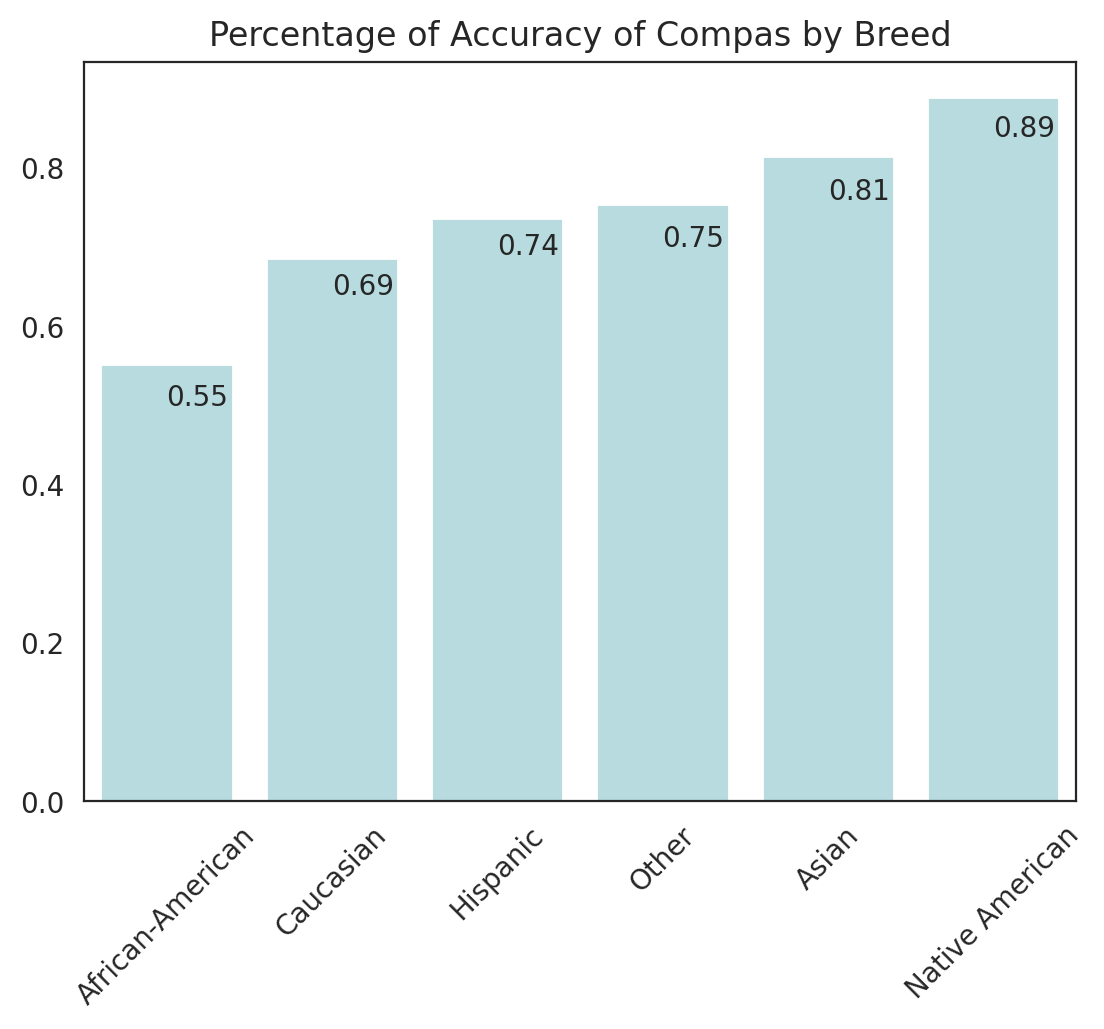

In [157]:
accuracy_race = df_final_c.groupby("race")["recid_comparison_column"].mean().reset_index()
ax= sns.barplot(data=accuracy_race,x="race",y="recid_comparison_column",color="powderblue")
plt.title("Percentage of Accuracy of Compas by Breed")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")
for num,text in zip(range(6),round(accuracy_race["recid_comparison_column"],2)):
    ax.text(num,text-0.05,text)

By sex we can see that males are more recidivists than females, both for Compas and in reality. In terms of accuracy there is no difference between the two (65%).


# Machine Learning Implementation


*   Balance Data
*   Apply Feature Blindness
*   Create Train/Validation Splits
*   Create Models
*   Compare Results





## Balance Data by Race and Sex

In [158]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11085 entries, 0 to 18315
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       6590 non-null   float64       
 1   compas_screening_date    11085 non-null  datetime64[ns]
 2   c_offense_date           11085 non-null  datetime64[ns]
 3   sex                      11085 non-null  category      
 4   age                      11085 non-null  int64         
 5   age_cat                  11085 non-null  category      
 6   race                     11085 non-null  category      
 7   c_charge_degree          11085 non-null  category      
 8   c_charge_desc            11077 non-null  object        
 9   days_b_screening_arrest  11085 non-null  float64       
 10  decile_score             11085 non-null  int64         
 11  is_recid                 11085 non-null  int64         
 12  r_offense_date           2139 non-nul

In [159]:
# Drop some of the unncessary columns from the dataframe
df_final = df_final.drop(columns = ['age_cat','compas_screening_date','c_offense_date','r_offense_date','vr_offense_date','is_violent_recid'])

In [160]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11085 entries, 0 to 18315
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       6590 non-null   float64 
 1   sex                      11085 non-null  category
 2   age                      11085 non-null  int64   
 3   race                     11085 non-null  category
 4   c_charge_degree          11085 non-null  category
 5   c_charge_desc            11077 non-null  object  
 6   days_b_screening_arrest  11085 non-null  float64 
 7   decile_score             11085 non-null  int64   
 8   is_recid                 11085 non-null  int64   
 9   c_case_number            11085 non-null  object  
 10  v_decile_score           11085 non-null  int64   
 11  score_text               11085 non-null  category
 12  days                     342 non-null    float64 
 13  two                      11085 non-null  int64   
 14  two_years_r

In [161]:
# Look at the balance of race
df_final['race'].value_counts()

,count
race,
African-American,5890
Caucasian,3664
Hispanic,835
Other,626
Asian,47
Native American,23


In [162]:
# Since the data is not balanced, we will balance it for race values of African-American and Caucasion

class_aa = df_final.query("race == 'African-American'").sample(n=3664,random_state=47)
class_caucasian = df_final.query("race == 'Caucasian'")
balanced_train = pd.concat([class_aa,class_caucasian], axis=0)
balanced_train['race'].value_counts()

,count
race,
African-American,3664
Caucasian,3664
Hispanic,0
Other,0
Asian,0
Native American,0


In [163]:
# Look at the balance of race
balanced_train['sex'].value_counts()

,count
sex,
Male,5837
Female,1491


In [164]:
# Since the data is not balanced, we will balance it for race values of male and female

class_m = balanced_train.query("sex == 'Male'").sample(n=1491,random_state=47)
class_f = balanced_train.query("sex == 'Female'")
final_balanced_train = pd.concat([class_m,class_f], axis=0)
final_balanced_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2982 entries, 3513 to 18303
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       1737 non-null   float64 
 1   sex                      2982 non-null   category
 2   age                      2982 non-null   int64   
 3   race                     2982 non-null   category
 4   c_charge_degree          2982 non-null   category
 5   c_charge_desc            2979 non-null   object  
 6   days_b_screening_arrest  2982 non-null   float64 
 7   decile_score             2982 non-null   int64   
 8   is_recid                 2982 non-null   int64   
 9   c_case_number            2982 non-null   object  
 10  v_decile_score           2982 non-null   int64   
 11  score_text               2982 non-null   category
 12  days                     82 non-null     float64 
 13  two                      2982 non-null   int64   
 14  two_years

## Feature Blindness for Race & Sex

In [165]:
# Remove Race, Sex, Race and Sex Features
df_final_noR = df_final.drop(columns=['race'])
df_final_noS = df_final.drop(columns=['sex'])
df_final_noRS = df_final.drop(columns=['race','sex'])

## Create Train/Test Splits


In [166]:
from sklearn.model_selection import train_test_split

# For the balanced data
X_balanced = final_balanced_train.drop(columns = ['is_recid'])
y_balanced = final_balanced_train['is_recid']
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

# For the race blinded data
X_noR = df_final_noR.drop(columns = ['is_recid'])
y_noR = df_final_noR['is_recid']
X_noR_train, X_noR_test, y_noR_train, y_noR_test = train_test_split(X_noR, y_noR, test_size=0.2, stratify=y_noR, random_state=42)

# For the sex blinded data
X_noS = df_final_noS.drop(columns = ['is_recid'])
y_noS = df_final_noS['is_recid']
X_noS_train, X_noS_test, y_noS_train, y_noS_test = train_test_split(X_noS, y_noS, test_size=0.2, stratify=y_noS, random_state=42)

# For the race & sex blinded data
X_noRS = df_final_noRS.drop(columns = ['is_recid'])
y_noRS = df_final_noRS['is_recid']
X_noRS_train, X_noRS_test, y_noRS_train, y_noRS_test = train_test_split(X_noRS, y_noRS, test_size=0.2, stratify=y_noRS, random_state=42)

In [167]:
X_balanced_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2385 entries, 368 to 10373
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       1420 non-null   float64 
 1   sex                      2385 non-null   category
 2   age                      2385 non-null   int64   
 3   race                     2385 non-null   category
 4   c_charge_degree          2385 non-null   category
 5   c_charge_desc            2383 non-null   object  
 6   days_b_screening_arrest  2385 non-null   float64 
 7   decile_score             2385 non-null   int64   
 8   c_case_number            2385 non-null   object  
 9   v_decile_score           2385 non-null   int64   
 10  score_text               2385 non-null   category
 11  days                     62 non-null     float64 
 12  two                      2385 non-null   int64   
 13  two_years_r              2385 non-null   int64   
 14  two_years_

In [168]:
X_noR_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8868 entries, 7503 to 4776
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       5291 non-null   float64 
 1   sex                      8868 non-null   category
 2   age                      8868 non-null   int64   
 3   c_charge_degree          8868 non-null   category
 4   c_charge_desc            8860 non-null   object  
 5   days_b_screening_arrest  8868 non-null   float64 
 6   decile_score             8868 non-null   int64   
 7   c_case_number            8868 non-null   object  
 8   v_decile_score           8868 non-null   int64   
 9   score_text               8868 non-null   category
 10  days                     261 non-null    float64 
 11  two                      8868 non-null   int64   
 12  two_years_r              8868 non-null   int64   
 13  two_years_v              8868 non-null   int64   
dtypes: categor

In [169]:
# Convert categorical data to dummy variables
X_balanced_train = pd.get_dummies(X_balanced_train[['sex','race','c_charge_degree','score_text']],drop_first=True)
X_balanced_test = pd.get_dummies(X_balanced_test[['sex','race','c_charge_degree','score_text']],drop_first=True)

X_noR_train = pd.get_dummies(X_noR_train[['sex','c_charge_degree','score_text']],drop_first=True)
X_noR_test = pd.get_dummies(X_noR_test[['sex','c_charge_degree','score_text']],drop_first=True)

X_noS_train = pd.get_dummies(X_noS_train[['race','c_charge_degree','score_text']],drop_first=True)
X_noS_test = pd.get_dummies(X_noS_test[['race','c_charge_degree','score_text']],drop_first=True)

X_noRS_train = pd.get_dummies(X_noRS_train[['c_charge_degree','score_text']],drop_first=True)
X_noRS_test = pd.get_dummies(X_noRS_test[['c_charge_degree','score_text']],drop_first=True)


## Create Models

In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

rf_model_balanced = RandomForestClassifier(random_state=0).fit(X_balanced_train, y_balanced_train)
rf_model_noR = RandomForestClassifier(random_state=0).fit(X_noR_train, y_noR_train)
rf_model_noS = RandomForestClassifier(random_state=0).fit(X_noS_train, y_noS_train)
rf_model_noRS = RandomForestClassifier(random_state=0).fit(X_noRS_train, y_noRS_train)

rfmodels = [rf_model_balanced, rf_model_noR, rf_model_noS, rf_model_noRS]
rfmodels_names = ["rf_model_balanced", "rf_model_noR", "rf_model_noS", "rf_model_noRS"]
rfX_tests = [X_balanced_test,X_noR_test,X_noS_test,X_noRS_test]
rfy_tests = [y_balanced_test,y_noR_test,y_noS_test,y_noRS_test]

dt_model_balanced = DecisionTreeClassifier(random_state=0).fit(X_balanced_train, y_balanced_train)
dt_model_noR = DecisionTreeClassifier(random_state=0).fit(X_noR_train, y_noR_train)
dt_model_noS = DecisionTreeClassifier(random_state=0).fit(X_noS_train, y_noS_train)
dt_model_noRS = DecisionTreeClassifier(random_state=0).fit(X_noRS_train, y_noRS_train)

dtmodels = [dt_model_balanced, dt_model_noR, dt_model_noS, dt_model_noRS]
dtmodels_names = ["dt_model_balanced", "dt_model_noR", "dt_model_noS", "dt_model_noRS"]
dtX_tests = [X_balanced_test,X_noR_test,X_noS_test,X_noRS_test]
dty_tests = [y_balanced_test,y_noR_test,y_noS_test,y_noRS_test]

## Evaluate the Models

In [171]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,f1_score

predictions = []
for i in range(len(rfmodels)):
  y_pred = rfmodels[i].predict(rfX_tests[i])
  acc = accuracy_score(rfy_tests[i], y_pred)
  roc = roc_auc_score(rfy_tests[i], y_pred)
  precision = precision_score(rfy_tests[i], y_pred)
  f1 = f1_score(rfy_tests[i], y_pred)

  print(f'For Model {rfmodels_names[i]}, Accuracy: {acc:.3f}, f1-score: {f1:.3f}, ROC_AUC: {roc:.3f}, Precision: {precision:.3f}')

For Model rf_model_balanced, Accuracy: 0.638, f1-score: 0.563, ROC_AUC: 0.630, Precision: 0.647
For Model rf_model_noR, Accuracy: 0.635, f1-score: 0.625, ROC_AUC: 0.635, Precision: 0.636
For Model rf_model_noS, Accuracy: 0.636, f1-score: 0.641, ROC_AUC: 0.637, Precision: 0.627
For Model rf_model_noRS, Accuracy: 0.631, f1-score: 0.636, ROC_AUC: 0.631, Precision: 0.621


In [172]:
predictions = []
for i in range(len(dtmodels)):
  y_pred = dtmodels[i].predict(dtX_tests[i])
  acc = accuracy_score(dty_tests[i], y_pred)
  roc = roc_auc_score(dty_tests[i], y_pred)
  precision = precision_score(dty_tests[i], y_pred)
  f1 = f1_score(dty_tests[i], y_pred)

  print(f'For Model {dtmodels_names[i]}, Accuracy: {acc:.3f}, f1-score: {f1:.3f}, ROC_AUC: {roc:.3f}, Precision: {precision:.3f}')

For Model dt_model_balanced, Accuracy: 0.640, f1-score: 0.559, ROC_AUC: 0.631, Precision: 0.654
For Model dt_model_noR, Accuracy: 0.635, f1-score: 0.625, ROC_AUC: 0.635, Precision: 0.636
For Model dt_model_noS, Accuracy: 0.638, f1-score: 0.642, ROC_AUC: 0.638, Precision: 0.629
For Model dt_model_noRS, Accuracy: 0.631, f1-score: 0.636, ROC_AUC: 0.631, Precision: 0.621


# SUMMARY

* The input dataset is unbalanced since one of the races predominates over the others, this can lead to biases in the preditions.
* We have cleaned and filtered the dataset to get homogeneous data.
* We have created a feature, which we will use to predict (two_year_r), which assures us that is has been a repeat offender within two years after the Compas report.
* We have balanced the data using undersampling to balance the number of rows by both race and sex.
* We have divided the data by applying feature blindness on race, sex, and both
* We have generated train/test splits using the different data blinded subsets
* We have trained models using the different feature blinded data
* We have generated results through